# ЛР3

1. Выберите временной ряд цен акций.
2. Подготовьте данные для обучения моделей машинного обучения (нормализация, создание признаков).
3. Разделите данные на обучающую и тестовую выборки. 
4. Реализуйте и обучите следующие модели: 
    - a) Логистическая регрессия 
    - b) Машина опорных векторов 
    - c) Модель случайного леса (Random Forest) 
    - d) Градиентный бустинг (например, XGBoost) 
5. Настройте гиперпараметры моделей с помощью кросс-валидации. 
6. Сделайте прогноз на тестовой выборке для каждой модели. 
7. Сравните результаты прогнозирования моделей между собой и с простыми методами (например, наивный прогноз). 
8. Визуализируйте результаты прогнозирования. 
9. Проанализируйте важность признаков для моделей, где это применимо. 
10. Сделайте выводы о эффективности различных подходов машинного обучения в прогнозировании цен акций.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
import json

In [2]:
data = pd.read_csv("AFLT_W1.csv", parse_dates=True, index_col="datetime")

data['SMA_5'] = data['close'].rolling(window=5).mean()
data['SMA_10'] = data['close'].rolling(window=10).mean()
data['Volatility'] = data['close'].rolling(window=5).std()
data.dropna(inplace=True)

scaler = StandardScaler()
features = ['open', 'high', 'low', 'volume', 'SMA_5', 'SMA_10', 'Volatility']
target = 'close'
data[features] = scaler.fit_transform(data[features])

# Для регрессии
X_reg = data[features]
y_reg = data['close']

# Для логистической регрессии
data['Price_Up'] = (data['close'] > data['close'].shift(1)).astype(int)
data.dropna(inplace=True)
X_log = data[features]
y_log = data['Price_Up']

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, shuffle=False)
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y_log, test_size=0.2, shuffle=False)

print(data.head())

                open      high       low  close    volume     SMA_5    SMA_10  \
datetime                                                                        
1999-11-21 -1.379255 -1.389058 -1.367118    2.2 -0.385497 -1.393102 -1.391942   
1999-11-28 -1.379255 -1.389058 -1.367118    2.2 -0.385397 -1.389707 -1.396443   
1999-12-12 -1.379255 -1.389058 -1.367118    2.2 -0.385516 -1.386461 -1.396693   
1999-12-19 -1.371787 -1.357666 -1.359418    3.5 -0.383844 -1.376975 -1.387990   
1999-12-26 -1.344405 -1.309371 -1.333749    5.4 -0.385364 -1.359749 -1.377988   

            Volatility  Price_Up  
datetime                          
1999-11-21   -0.868634         0  
1999-11-28   -0.862290         0  
1999-12-12   -0.882967         0  
1999-12-19   -0.737849         1  
1999-12-26   -0.417297         1  


In [3]:
models = {
    'LogisticRegression': {
        'model': LogisticRegression(n_jobs=-1),
        'params': {
            'penalty': ['l2', None],
            'solver': ['lbfgs', 'newton-cg', 'sag'],
            'C': [0.1, 1, 10]
        },
        'X_train': X_log_train,
        'X_test': X_log_test,
        'y_train': y_log_train,
        'y_test': y_log_test,
        'metric': accuracy_score
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'epsilon': [0.1, 0.5],
            'gamma': ['scale', 0.1, 1]
        },
        'X_train': X_reg_train,
        'X_test': X_reg_test,
        'y_train': y_reg_train,
        'y_test': y_reg_test,
        'metric': mean_absolute_error
    },
    'RandomForest': {
        'model': RandomForestRegressor(n_jobs=-1),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10],
            'criterion': ['squared_error', 'absolute_error'],
            'max_features': ['sqrt', None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        },
        'X_train': X_reg_train,
        'X_test': X_reg_test,
        'y_train': y_reg_train,
        'y_test': y_reg_test,
        'metric': mean_absolute_error
    },
    'XGBoost': {
        'model': XGBRegressor(n_jobs=-1),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'max_depth': [6, 10],
            'subsample': [0.7, 1.0],
            'colsample_bytree': [0.7, 1.0],
            'gamma': [0, 0.1]
        },
        'X_train': X_reg_train,
        'X_test': X_reg_test,
        'y_train': y_reg_train,
        'y_test': y_reg_test,
        'metric': mean_absolute_error
    }
}

In [4]:
%%time
results = {}
for title, config in models.items():
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=5,
        scoring='neg_mean_absolute_error' if title != 'LogisticRegression' else 'accuracy',
        n_jobs=-1
    )
    grid.fit(config['X_train'], config['y_train'])
    
    best_params = grid.best_params_
    predictions = grid.predict(config['X_test'])
    
    metric_value = config['metric'](config['y_test'], predictions)
    results[title] = {
        'best_params': best_params,
        'metric_value': metric_value
    }
    
    with open(f'{title}_best_params.json', 'w') as f:
        json.dump({'best_params': best_params, 'metric_value': metric_value}, f, indent=4)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


CPU times: total: 13.9 s
Wall time: 4min 50s


In [20]:
import json

# Загрузка лучших параметров из JSON-файлов
best_params = {}
for title in ["SVR", "RandomForest", "XGBoost", "LogisticRegression"]:
    with open(f'{title}_best_params.json', 'r') as f:
        best_params[title] = json.load(f)['best_params']

# Создание моделей с лучшими параметрами
SVR_model = SVR(**best_params["SVR"])
RF_model = RandomForestRegressor(**best_params["RandomForest"])
XGB_model = XGBRegressor(**best_params["XGBoost"])
LR_model = LogisticRegression(**best_params["LogisticRegression"])

# Словарь с моделями
forecast_models = {
    "SVR": SVR_model,
    "RandomForest": RF_model,
    "XGBoost": XGB_model,
    "LogisticRegression": LR_model,
}

print("SVR", SVR_model)
print("\nRandomForest", RF_model)
print("\nXGBoost", XGB_model)
print("\nLogisticRegression", LR_model)


SVR SVR(C=10, kernel='linear')

RandomForest RandomForestRegressor(criterion='absolute_error', max_features=None)

XGBoost XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

LogisticRegression LogisticRegression(C=0.1, penalty=None)


In [53]:
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, target):
    """
    Функция для прогнозирования, расчета метрик и визуализации результатов.
    Параметры:
    - model: модель для обучения и прогнозирования.
    - model_name: название модели (строка).
    - X_train: обучающая выборка (признаки).
    - y_train: обучающая выборка (целевая переменная).
    - X_test: тестовая выборка (признаки).
    - y_test: тестовая выборка (целевая переменная).
    - target: название целевой переменной (строка).
    """
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Прогнозирование
    forecast = model.predict(X_test)
    
    # Расчет метрик MAE и RMSE
    mae = mean_absolute_error(y_test, forecast)
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    print(f'{model_name} MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    
    # Визуализация прогноза
    plt.figure(figsize=(12, 6))
    plt.plot(data.iloc[-90:].index, data[target].iloc[-90:], label='Исходные данные')
    plt.plot(data.iloc[-30:].index, forecast, label='Прогноз')
    plt.title(model_name)
    plt.xlabel('Дни')
    plt.ylabel('Прогнозируемая цена')
    plt.legend()
    plt.show()

SVR MAE: 0.7716, RMSE: 1.0328


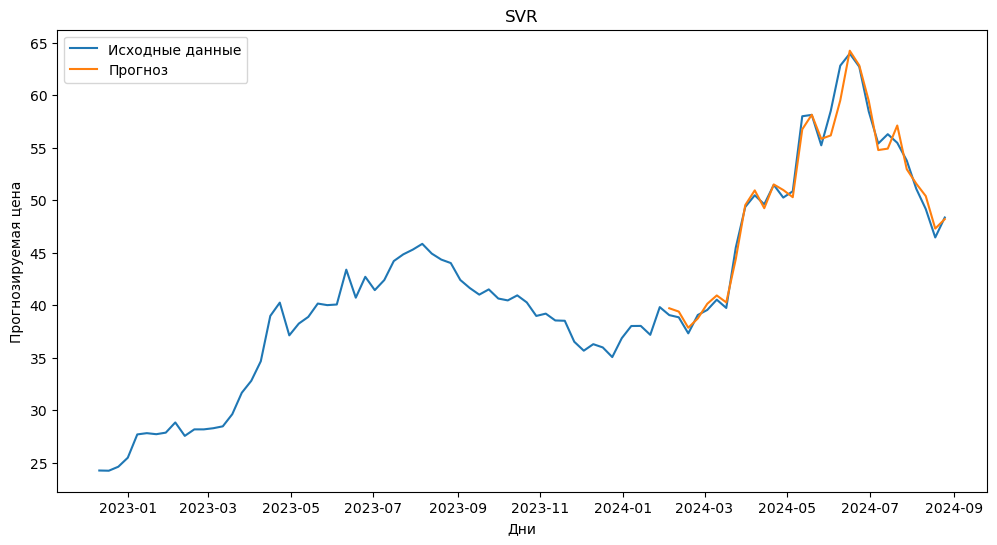

In [54]:
evaluate_model(SVR_model, "SVR", data[features].iloc[:-30], data[target].iloc[:-30], data[features].iloc[-30:], data[target].iloc[-30:], target)


Random Forest MAE: 1.1375, RMSE: 1.5496


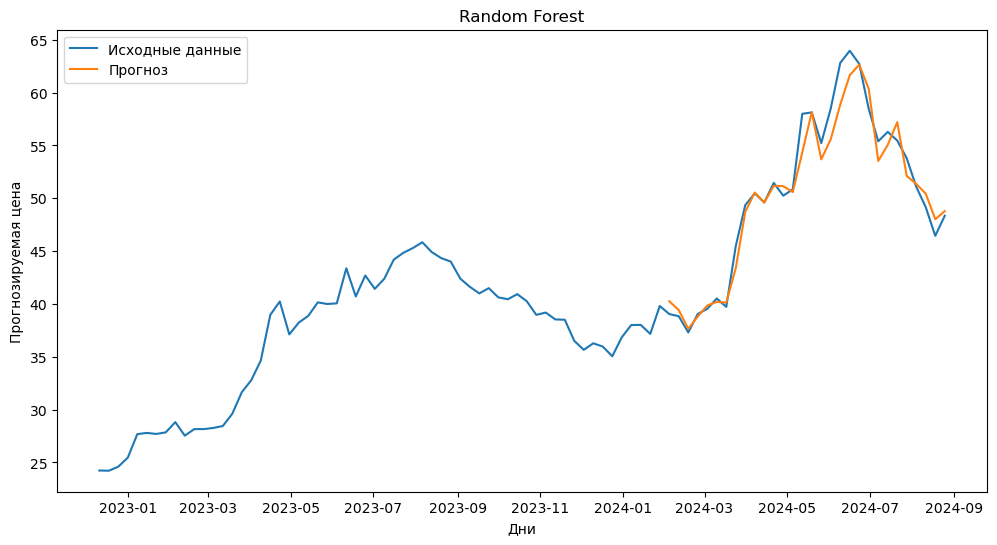

In [55]:
evaluate_model(RF_model, "Random Forest", data[features].iloc[:-30], data[target].iloc[:-30], data[features].iloc[-30:], data[target].iloc[-30:], target)

XGBoost MAE: 1.1765, RMSE: 1.7296


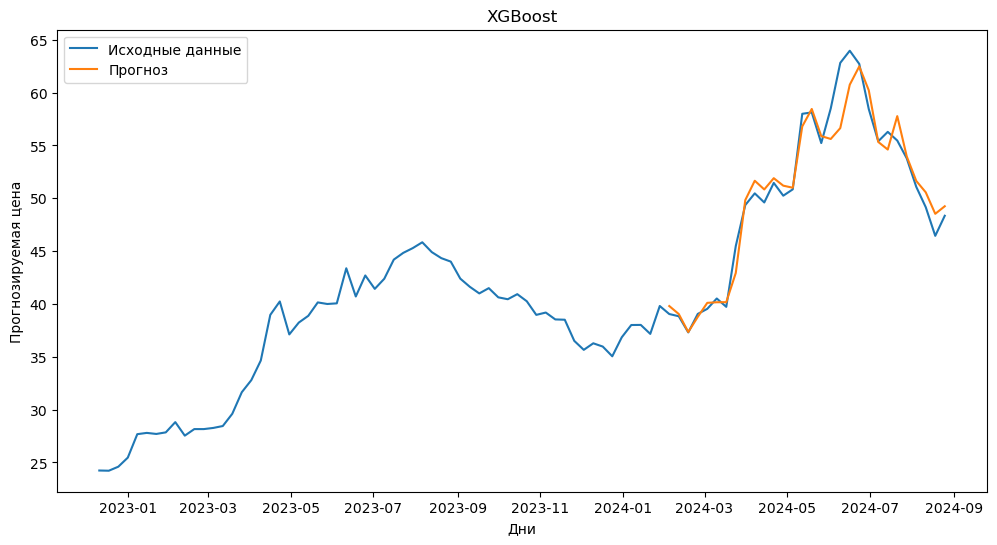

In [56]:
evaluate_model(XGB_model, "XGBoost", data[features].iloc[:-30], data[target].iloc[:-30], data[features].iloc[-30:], data[target].iloc[-30:], target)

In [32]:
# Прогнозирование для модели Logistic Regression
print("Прогнозирование для модели Logistic Regression")
LR_model.fit(data[features].iloc[:-30], data["Price_Up"].iloc[:-30])
lr_forecast = LR_model.predict(data[features].iloc[-30:])

# Вывод прогноза в виде списка
print(f"Прогноз логистической регрессии: {lr_forecast.tolist()}")
print(f"Факт (Price_Up)                : {data['Price_Up'].iloc[-30:].tolist()}")# Точность предсказания колебаний
lr_accuracy = accuracy_score(data["Price_Up"].iloc[-30:], lr_forecast)
print(f'Logistic Regression Точность предсказания колебаний: {lr_accuracy:.4f}')

# Для логистической регрессии визуализация прогноза не имеет смысла, так как это классификация

Прогнозирование для модели Logistic Regression
Прогноз логистической регрессии: [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Факт (Price_Up)                : [0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
Logistic Regression Точность предсказания колебаний: 0.7667


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Прогнозирование с использованием скользящего среднего (окно = 50)
Скользящее среднее MAE: 6.2560, RMSE: 7.2806


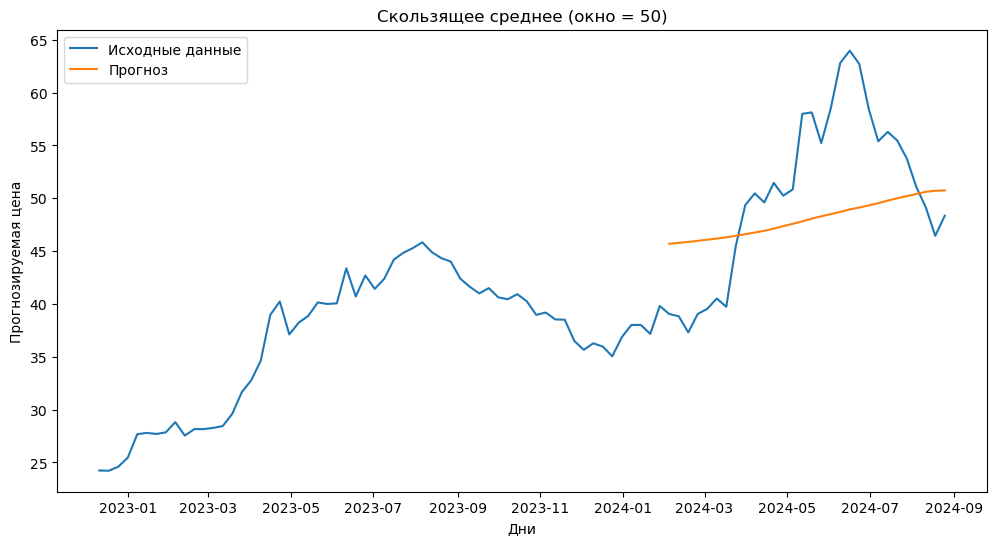

Прогнозирование со случайными скачками
Случайные скачки MAE: 11.4835, RMSE: 13.6866


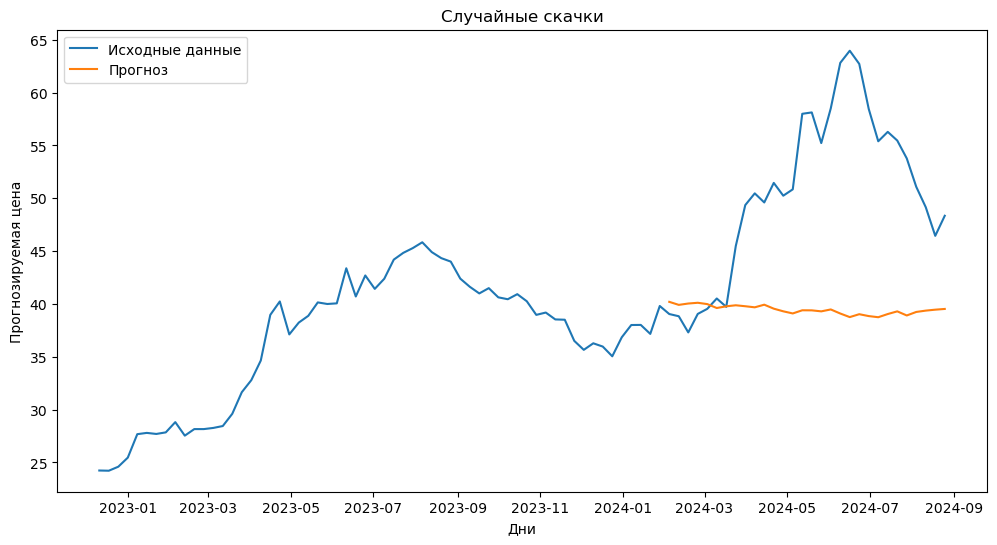

In [28]:
# Функция для прогнозирования с использованием скользящего среднего
def forecast_with_moving_average():
    forecast_values = []
    current_window = data[target].iloc[-50:].tolist()
    for _ in range(30):
        new_value = np.mean(current_window)
        forecast_values.append(new_value)
        current_window.append(new_value)
        if len(current_window) > 50:
            current_window.pop(0)
    return forecast_values

# Функция для прогнозирования со случайными скачками
def random_change_forecast():
    last_price = data[target].iloc[-31]
    forecast = []
    for _ in range(30):
        change_percentage = np.random.uniform(-0.01, 0.01)
        new_price = last_price * (1 + change_percentage)
        forecast.append(new_price)
        last_price = new_price
    return forecast

# Прогнозирование с использованием скользящего среднего
print("Прогнозирование с использованием скользящего среднего (окно = 50)")
moving_average_forecast = forecast_with_moving_average()

# Метрики MAE и RMSE
ma_mae = mean_absolute_error(data[target].iloc[-30:], moving_average_forecast)
ma_rmse = np.sqrt(mean_squared_error(data[target].iloc[-30:], moving_average_forecast))
print(f'Скользящее среднее MAE: {ma_mae:.4f}, RMSE: {ma_rmse:.4f}')

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(data.iloc[-90:].index, data[target].iloc[-90:], label='Исходные данные')
plt.plot(data.iloc[-30:].index, moving_average_forecast, label='Прогноз')
plt.title("Скользящее среднее (окно = 50)")
plt.xlabel('Дни')
plt.ylabel('Прогнозируемая цена')
plt.legend()
plt.show()

# Прогнозирование со случайными скачками
print("Прогнозирование со случайными скачками")
random_forecast = random_change_forecast()

# Метрики MAE и RMSE
random_mae = mean_absolute_error(data[target].iloc[-30:], random_forecast)
random_rmse = np.sqrt(mean_squared_error(data[target].iloc[-30:], random_forecast))
print(f'Случайные скачки MAE: {random_mae:.4f}, RMSE: {random_rmse:.4f}')

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(data.iloc[-90:].index, data[target].iloc[-90:], label='Исходные данные')
plt.plot(data.iloc[-30:].index, random_forecast, label='Прогноз')
plt.title("Случайные скачки")
plt.xlabel('Дни')
plt.ylabel('Прогнозируемая цена')
plt.legend()
plt.show()

In [46]:
# Словарь для хранения важности признаков для каждой модели
feature_importance_results = {}

# Оценка важности признаков для RandomForest XGBoost LogisticRegression 
RF_model.fit(data[features].iloc[:-30], data[target].iloc[:-30])
rf_feature_importances = RF_model.feature_importances_
feature_importance_results["RandomForest"] = rf_feature_importances

XGB_model.fit(data[features].iloc[:-30], data[target].iloc[:-30])
xgb_feature_importances = XGB_model.feature_importances_
feature_importance_results["XGBoost"] = xgb_feature_importances

LR_model.fit(data[features].iloc[:-30], data["Price_Up"].iloc[:-30])
lr_coefficients = LR_model.coef_[0]
feature_importance_results["LogisticRegression"] = lr_coefficients

SVR_model.fit(data[features].iloc[:-30], data[target].iloc[:-30])
# Для SVR важность признаков не так очевидна, но можно использовать абсолютные значения коэффициентов
svr_coefficients = SVR_model.coef_.flatten() if hasattr(SVR_model, 'coef_') else None
if svr_coefficients is not None:
    feature_importance_results["SVR"] = svr_coefficients
else:
    print("SVR не предоставляет коэффициентов для оценки важности признаков.")
    feature_importance_results["SVR"] = None
    
def plot_feature_importance(model_name, features, importance):
    """
    Функция для отображения важности признаков на столбчатой диаграмме.
    Параметры:
    - model_name: название модели (строка).
    - features: список признаков (список строк).
    - importance: список значений важности признаков (список чисел).
    """
    plt.figure(figsize=(10, 6))
    plt.barh(features, importance, color='skyblue')
    plt.title(f"Важность признаков для модели {model_name}")
    plt.xlabel("Важность")
    plt.ylabel("Признаки")
    plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


# Отрицательные значения = обратная зависимость признака от целевой переменной

## RandomForest оценивает high и low

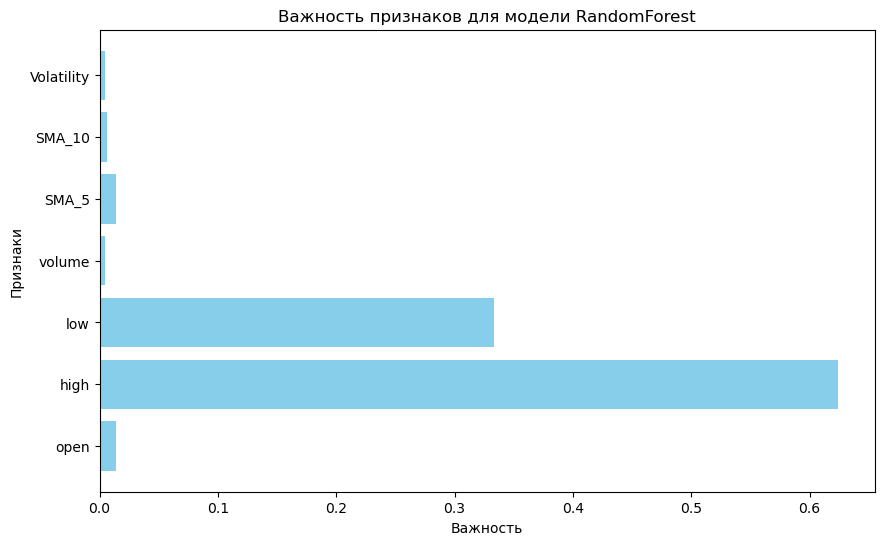

In [47]:
plot_feature_importance("RandomForest", features, feature_importance_results["RandomForest"])

## XGBoost оценивает low и high 

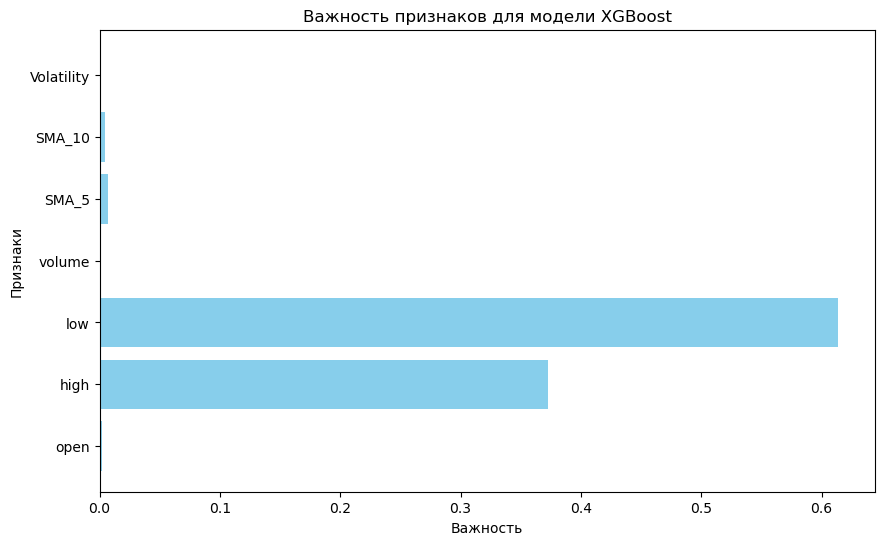

In [48]:
plot_feature_importance("XGBoost", features, feature_importance_results["XGBoost"])

## LogisticRegression оценивает open и high, low 

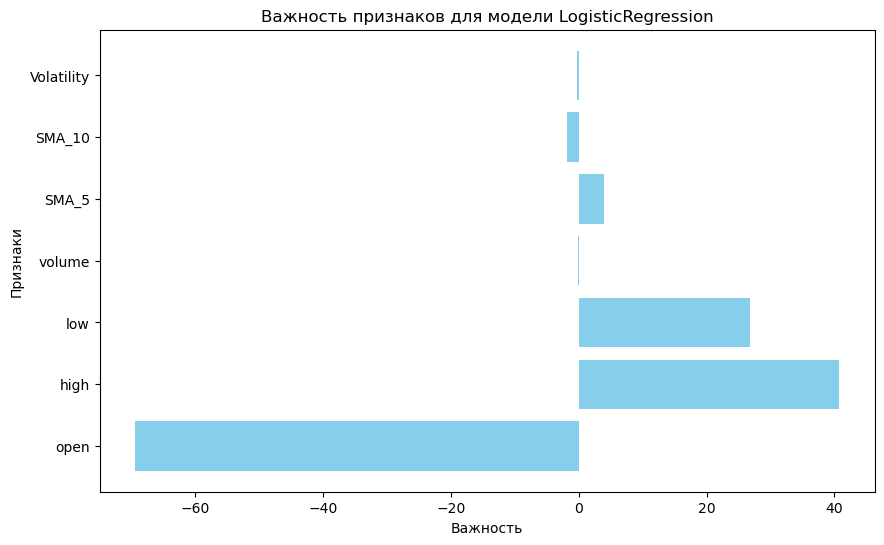

In [49]:
plot_feature_importance("LogisticRegression", features, feature_importance_results["LogisticRegression"])

## SVR активнее чем другие использует SMA 

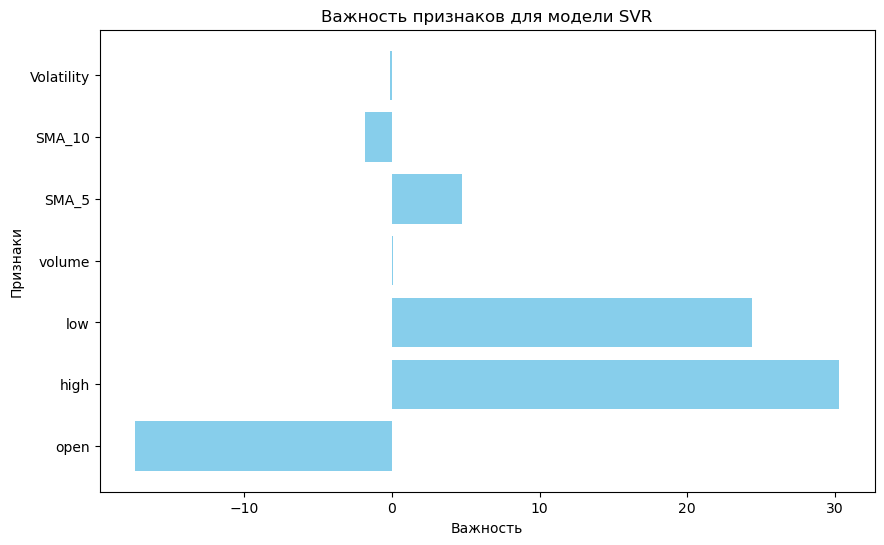

In [50]:
plot_feature_importance("SVR", features, feature_importance_results["SVR"])

## Некоторые признаки - лишние, они почти не влияют на резултат, а только тормозят вычисления, например, признаки 'volume', и 'Volatility'